In [1]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt

# Task 0
Data extraction: get the data from 3 tables & combine it into single `.csv` file.
After that read this file using pandas to create Dataframe.
So it will be all joined data in 1 dataframe. Quick check - should be 74818 rows in it.

In [2]:
conn = sqlite3.connect("../db.sqlite3")
combined_df = pd.read_sql_query('''
    SELECT *
    FROM restaurant_order AS o
    INNER JOIN restaurant_orderitem AS oi ON o.id = oi.order_id
    INNER JOIN restaurant_product AS p ON oi.product_id = p.id
''', conn)

combined_df.to_csv("combined_data.csv", index=False)
combined_df = pd.read_csv("combined_data.csv")

print("Number of rows in the DataFrame:", len(combined_df))
conn.close()

Number of rows in the DataFrame: 74818


# Task 1
Get Top 10 most popular products in restaurant sold by Quantity.
Count how many times each product was sold and create a pie chart with percentage of popularity (by quantity) for top 10 of them.

Example:

![pie chart](../demo/pie.png)

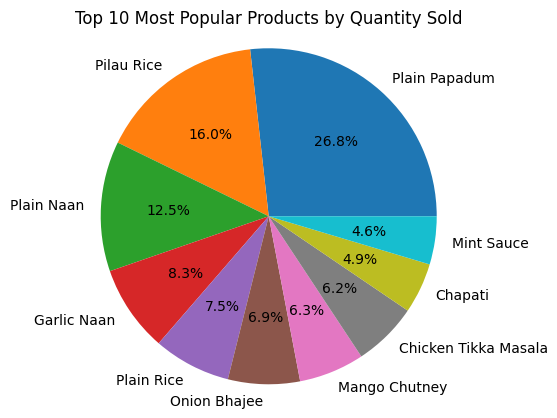

In [4]:
conn = sqlite3.connect("../db.sqlite3")
query = '''
    SELECT p.name, SUM(oi.quantity) AS total_quantity
    FROM restaurant_product AS p
    INNER JOIN restaurant_orderitem AS oi ON p.id = oi.product_id
    GROUP BY p.name
    ORDER BY total_quantity DESC
    LIMIT 10
'''
top_products_df = pd.read_sql_query(query, conn)
plt.pie(top_products_df["total_quantity"], labels=top_products_df["name"], autopct='%1.1f%%')
plt.title("Top 10 Most Popular Products by Quantity Sold")
plt.axis("equal")
plt.show()
conn.close()


# Task 2
Calculate `Item Price` (Product Price * Quantity) for each Order Item in dataframe.
And Make the same Top 10 pie chart, but this time by `Item Price`. So this chart should describe not the most popular products by quantity, but which products (top 10) make the most money for restaurant. It should be also with percentage.

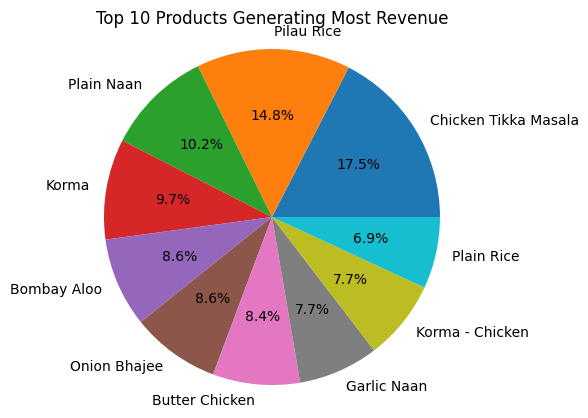

In [5]:
conn = sqlite3.connect("../db.sqlite3")
cursor = conn.cursor()
cursor.execute('''
    SELECT p.name, (oi.quantity * p.price) AS item_price
    FROM restaurant_orderitem AS oi
    JOIN restaurant_product AS p ON oi.product_id = p.id
''')
result = cursor.fetchall()
columns = ["name", "item_price"]
df = pd.DataFrame(result, columns=columns)
revenue_df = df.groupby("name")["item_price"].sum().reset_index()
top_revenue_df = revenue_df.nlargest(10, "item_price")

plt.pie(top_revenue_df["item_price"], labels=top_revenue_df["name"], autopct='%1.1f%%')
plt.title("Top 10 Products Generating Most Revenue")
plt.axis("equal")
plt.show()

conn.close()


# Task 3
Calculate `Order Hour` based on `Order Datetime`, which will tell about the specific our the order was created (from 0 to 23). Using `Order Hour` create a bar chart, which will tell the total restaurant income based on the hour order was created. So on x-axis - it will be values from 0 to 23 (hours), on y-axis - it will be the total sum of order prices, which were sold on that hour.

Example:

![bar chart](../demo/bar.png)

In [ ]:
conn = sqlite3.connect("../db.sqlite3")
query = '''
    SELECT strftime('%H', restaurant_order.datetime) AS order_hour, SUM(restaurant_product.price) AS total_income
    FROM restaurant_orderitem
    JOIN restaurant_order ON restaurant_orderitem.order_id = restaurant_order.id
    JOIN restaurant_product ON restaurant_orderitem.product_id = restaurant_product.id
    GROUP BY order_hour
    ORDER BY order_hour
'''
result = conn.execute(query).fetchall()
order_hours = [int(row[0]) for row in result]
total_incomes = [row[1] for row in result]
plt.bar(order_hours, total_incomes)
plt.xlabel("Order Hour")
plt.ylabel("Total Income")
plt.title("Total Restaurant Income by Order Hour")
plt.xticks(range(24))
plt.show()
conn.close()



# Task 4
Make similar bar chart, but right now with `Order Day Of The Week` (from Monday to Sunday), and also analyze total restaurant income by each day of the week.

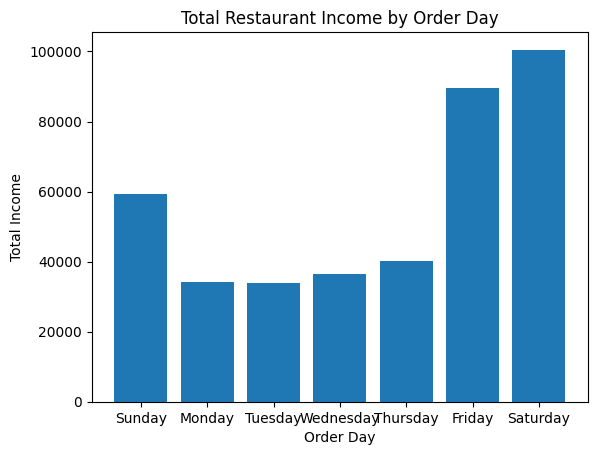

In [6]:
conn = sqlite3.connect("../db.sqlite3")

query = '''
    SELECT strftime('%w', datetime) AS order_day, SUM(price) AS total_income
    FROM restaurant_orderitem
    JOIN restaurant_order ON restaurant_orderitem.order_id = restaurant_order.id
    JOIN restaurant_product ON restaurant_orderitem.product_id = restaurant_product.id
    GROUP BY order_day
    ORDER BY order_day
'''

result = conn.execute(query).fetchall()
order_days = [int(row[0]) for row in result]
total_incomes = [row[1] for row in result]
weekdays = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]
plt.bar(order_days, total_incomes)
plt.xlabel("Order Day")
plt.ylabel("Total Income")
plt.title("Total Restaurant Income by Order Day")
plt.xticks(order_days, weekdays)
plt.show()

conn.close()
